In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
from IPython.core.display import display, HTML

display(HTML('''<style>
.container {width:98% !important;}
.dataframe th{font: bold 14px times; background: #0ea; text-align: right;}
.dataframe td{font: 14px courier; background: #fff; text-align: right;}
.output_subarea.output_text.output_stream.output_stderr {background: #fff; font-style: italic;}
</style>'''))

In [2]:
try:
    run_once
except NameError:
    run_once = False
if not run_once:
    run_once = True
    
    import time
    import logging
    reload(logging)
    FORMAT = '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
    logpath = '/notebooks/logs/correlation.log'
    logging.basicConfig(filename=logpath,level=logging.DEBUG, format=FORMAT)
    print("logging to %s" % (logpath))
    logger = logging.getLogger()
    #logger.basicConfig(filename='/notebooks/Export Microbiome to database.log',level=logging.DEBUG)
    logger.setLevel(logging.DEBUG)
    ch = logging.StreamHandler()
    ch.setLevel(logging.DEBUG)

    # create formatter
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

    # add formatter to ch
    ch.setFormatter(formatter)

    # add ch to logger
    logger.addHandler(ch)

logging to /notebooks/logs/correlation.log


In [3]:
%matplotlib inline
import pandas, pandas.io
import re
import seaborn as sns
import math
import scipy, scipy.stats
import matplotlib.pyplot as plt
import numpy as np
import string
import sys, os, os.path
import networkx as nx
import community
# pip install python-louvain
logging.getLogger('boto').setLevel(logging.INFO)

2016-12-15 17:53:33,606 - root - INFO - Generating grammar tables from /usr/lib/python2.7/lib2to3/Grammar.txt
2016-12-15 17:53:33,630 - root - INFO - Generating grammar tables from /usr/lib/python2.7/lib2to3/PatternGrammar.txt


In [10]:
def select(res, substring=None, ids = None):
    """Helper function to search network dataframe.
    """
    if substring:
        ss_sel = _select_substring(res,  substring.lower() )
    if ids:
        raise Exception("id unimplemented")
        id_sel = _select_ids(res, ids[0], ids[1])
    return res[ss_sel]

def _select_ids( res, datasource_id, variable_id ):
    sel = (res.ds_id_1 == datasource_id & res.variable_id_1 == variable_id )
    sel = sel | (res.ds_id_2 == datasource_id & res.variable_id_2 == variable_id )
    return sel
def _select_substring( res, substring ):
    
    ann = res.annotations_1.unique().tolist() + res.annotations_2.unique().tolist()
    sel = res.annotations_1 == ''
    text =  set([a for a in ann if a.lower().find(substring) >= 0.0])
    for an in text:
        sel = sel | (res.annotations_1 == an)
        sel = sel | (res.annotations_2 == an) 
    return sel

In [11]:
res = pandas.read_pickle('data/community/full.correlation.network.pkl')

In [12]:
max_adj_pval = 0.05
sig = res[(res.pval_adj < max_adj_pval)]
print sig.shape

(21477, 12)


In [13]:
# remove coaching correlations
sub = select(sig, 'COACH')
remove = sub.index
mask1 = sig.index.isin(remove)
print mask1.sum()
# remove AGES correlations
sub = select(sig, 'AGES')
remove = sub.index
mask2 = sig.index.isin(remove)
print mask2.sum()
sig = sig[~(mask1 | mask2)]
sig.shape

47
229


(21201, 12)

In [14]:
rem = pandas.read_csv('data/community/duplicate_measurements.05012016.txt', sep='\t', header=None)
rem.columns = ['ann1', 'ann2']

mask = []
for index, row in sig.iterrows():
    
    found = False
    for index2, row2 in rem.iterrows():
        
        if (row['annotations_1']==row2['ann1']) and (row['annotations_2']==row2['ann2']):
            found = True
            break;
        elif (row['annotations_1']==row2['ann2']) and (row['annotations_2']==row2['ann1']):
            found = True
            break;

    mask.append(found)
    
mask = np.array(mask)
sig = sig[~mask]
sig.shape

(21126, 12)

In [15]:
# Save resulting network to text file
#sig.to_csv('data/community/correlation_network.sig.nodups.FULL.txt', sep='\t')
sig.to_pickle('data/community/correlation_network.sig.nodups.FULL.pkl')

In [16]:
mask = []
# Now remove all correlations between pairwise elements
for index, row in sig.iterrows():
    
    cat1 = row['annotations_1'][0:5]
    cat2 = row['annotations_2'][0:5]
    
    if (cat1 == cat2):
        mask.append(False)
    else:
        mask.append(True)
        
sig = sig[mask]
print sig.shape

(3471, 12)


In [17]:
sig.to_pickle('data/community/correlation_network.nodups.INTRAOMIC.pkl')

In [18]:
print select(sig, 'GENOM').shape
print select(sig, 'MICRO').shape
print select(sig, 'PROTE').shape
print select(sig, 'METAB').shape
print select(sig, 'CHEMS').shape

(20, 12)
(46, 12)
(207, 12)
(3310, 12)
(3367, 12)


In [19]:
## Load data into networkx
g = nx.Graph()

In [20]:
# add a set of nodes
nodes = sig['annotations_1'].append(sig['annotations_2']).unique()
datatype = {}
super_pathways = {}
sub_pathways = {}

# Loop over nodes and get type
for e in nodes:
    tokens = e.split('.')

    datatype[e] = tokens[0]
    if (datatype[e]=='METAB'):
        super_pathways[e] = tokens[2]
        sub_pathways[e] = tokens[3]
    
g.add_nodes_from(list(nodes))
nx.set_node_attributes(g, 'type', datatype)
nx.set_node_attributes(g, 'super_pathway', super_pathways)
nx.set_node_attributes(g, 'sub_pathway', sub_pathways)

In [21]:
# Add a set of edges
edges = []
attributes = []
for row in sig.iterrows():
    g.add_edge(row[1]['annotations_1'], row[1]['annotations_2'], {'weight':abs(row[1]['coefficient']), 'non_abs_weight':row[1]['coefficient'], 'pvalue':row[1]['pval_adj']})  

In [22]:
# Count number of nodes and edges
print g.number_of_nodes(), g.number_of_edges()

766 3471


In [23]:
def girvan_newman(G, k=None, weight=None):
    """Find communities in graph using Girvan–Newman method.

    Parameters
    ----------
    G : NetworkX graph

    weight : string, optional (default=None)
       Edge data key corresponding to the edge weight.

    Returns
    -------
    List of tuples which contains the clusters of nodes.

    Examples
    --------
    >>> G = nx.path_graph(10)
    >>> comp = girvan_newman(G)
    >>> comp[0]
    ([0, 1, 2, 3, 4], [8, 9, 5, 6, 7])

    Notes
    -----
    The Girvan–Newman algorithm detects communities by progressively removing
    edges from the original graph. Algorithm removes edge with the highest
    betweenness centrality at each step. As the graph breaks down into pieces,
    the tightly knit community structure is exposed and result can be depicted
    as a dendrogram.
    """
    # The copy of G here must include the edge weight data.
    g = G.copy().to_undirected()
    components = []
    while g.number_of_edges() > 0:
        print "Number of edges", g.number_of_edges()
        sys.stdout.flush()
        _remove_max_edge(g, k, weight)
        components.append(tuple(list(H)
                                for H in nx.connected_component_subgraphs(g)))
    return components

def _remove_max_edge(G, k=None, weight=None):
    """
    Removes edge with the highest value on betweenness centrality.

    Repeat this step until more connected components than the connected
    components of the original graph are detected.

    It is part of Girvan–Newman algorithm.

    :param G: NetworkX graph
    :param weight: string, optional (default=None) Edge data key corresponding
    to the edge weight.
    """
    number_components = nx.number_connected_components(G)
    #print number_components
    while nx.number_connected_components(G) <= number_components:
        betweenness = nx.edge_betweenness_centrality(G, k=k, weight=weight)
        #print "finished betweenness", nx.number_connected_components(G), number_components
        max_value = max(betweenness.values())
        #print "max_value", max_value
        # Use a list of edges because G is changed in the loop
        for edge in list(G.edges()):
            if betweenness[edge] == max_value:
                G.remove_edge(*edge)

In [24]:

communities = girvan_newman(g, weight='weight')

# Save the community to a file
cindex = 0
gindex = 0

with open('data/community/generated.communities.sig.nodups.INTRAOMIC.txt', 'w') as f:

    cindex = 0
    for community_set in communities:
        gindex = 0
        for graph in community_set:

            for node in graph:
                f.write("%d\t%d\t%s\n"%(cindex, gindex, node))

            gindex += 1

        cindex += 1



Number of edges 3471
Number of edges 3467
Number of edges 3464
Number of edges 3463
Number of edges 3459
Number of edges 3446
Number of edges 3438
Number of edges 3435
Number of edges 3429
Number of edges 3426
Number of edges 3420
Number of edges 3407
Number of edges 3395
Number of edges 3374
Number of edges 3354
Number of edges 3350
Number of edges 3347
Number of edges 3343
Number of edges 3328
Number of edges 3295
Number of edges 3293
Number of edges 3288
Number of edges 3233
Number of edges 3216
Number of edges 3190
Number of edges 3094
Number of edges 3029
Number of edges 2998
Number of edges 2970
Number of edges 2962
Number of edges 2923
Number of edges 2910
Number of edges 2906
Number of edges 2882
Number of edges 2855
Number of edges 2845
Number of edges 2817
Number of edges 2807
Number of edges 2693
Number of edges 2687
Number of edges 2659
Number of edges 2612
Number of edges 2588
Number of edges 2576
Number of edges 2565
Number of edges 2561
Number of edges 2554
Number of edg

In [25]:
len(communities)

274

In [26]:
nnodes = []
nedges = []
for e in communities[61]:
    if (len(e)>1):
        
        sg = g.subgraph(e)
        nnodes.append(sg.number_of_nodes())
        nedges.append(sg.number_of_edges())
        
print "Number of communities", len(nnodes), len(nedges)
print sorted(nnodes)
print "Node stats", np.mean(nnodes), np.max(nnodes), np.min(nnodes), np.sum(nnodes)
print "Edge stats", np.mean(nedges), np.max(nedges), np.min(nedges), np.sum(nedges)

# Get percentage of nodes used
print "Percent of nodes in a community", float(np.sum(nnodes)) / g.number_of_nodes()
print "Percent of edges in a community", float(np.sum(nedges)) / g.number_of_edges()

Number of communities 70 70
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 7, 8, 8, 8, 8, 8, 8, 8, 10, 10, 11, 13, 14, 18, 19, 20, 28, 59, 67, 256]
Node stats 10.9428571429 256 2 766
Edge stats 36.0428571429 1721 1 2523
Percent of nodes in a community 1.0
Percent of edges in a community 0.726879861711


70
36.0428571429 1721 1 2523 3.0


(array([ 68.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  1.00000000e+00,   1.73000000e+02,   3.45000000e+02,
          5.17000000e+02,   6.89000000e+02,   8.61000000e+02,
          1.03300000e+03,   1.20500000e+03,   1.37700000e+03,
          1.54900000e+03,   1.72100000e+03]),
 <a list of 10 Patch objects>)

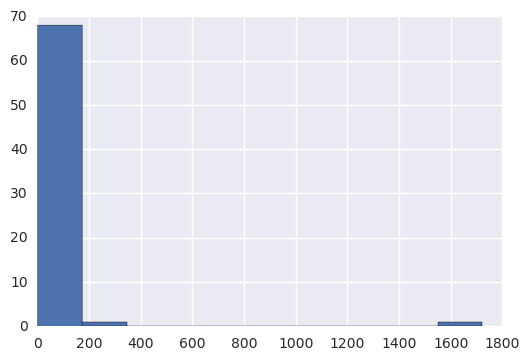

In [27]:
print len(nedges)
print np.mean(nedges), np.max(nedges), np.min(nedges), np.sum(nedges), np.median(nedges)
plt.hist(nedges)

In [ ]:
# Load the community
communities_dict = []

current_community = None
current_subgraph = None
data = {}

# Load the community as a set of dictionaries
with open('data/community/generated.communities.sig.nodups.INTRAOMIC.txt', 'r') as f:

    for line in f:
        
        tokens = line.strip().split('\t')
        c = int(tokens[0])
        subgraph = int(tokens[1])
        node = tokens[2]

        if (current_community is None):
            current_community = c
            current_subgraph = subgraph
            data[node] = subgraph
            
        elif (c != current_community):          
            communities_dict.append(data)
            data = {}
            current_community = c
            current_subgraph = subgraph
            
        data[node] = subgraph
        
    #if (len(data)>0):
    #    subgraphs.append(data)
        
    #if (len(subgraphs)>0):
    #    communities_dict.append(subgraphs)
            

In [ ]:
# Note: this takes about an hour
import community
results = []
count = 0
mods = []
for c in communities_dict:
    print c
    mod = community.modularity(c, g)
    results.append((count, mod))
    mods.append(mod)
    count += 1
    
df = pandas.DataFrame(results, columns=['index', 'modularity']).sort_values('modularity', ascending=False)


In [36]:
df.shape

(273, 2)

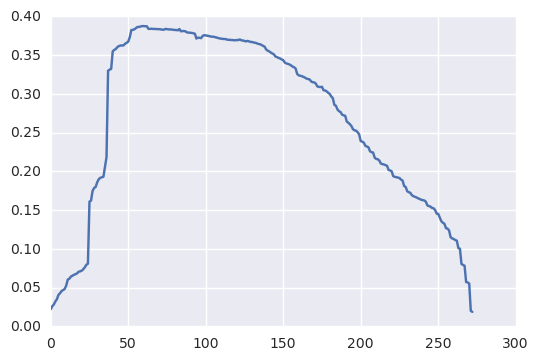

In [37]:
plt.plot(mods)
plt.ylabel='Modularity'
plt.xlabel='Community analysis iteration'
plt.show()

In [38]:
# Load the community as a list of lists
communities = []

current_community = None
current_subgraph = None
data = []
subgraphs = []

# Load the community as a set of dictionaries
with open('data/community/generated.communities.sig.nodups.INTRAOMIC.txt', 'r') as f:

    for line in f:
        
        tokens = line.strip().split('\t')
        c = int(tokens[0])
        subgraph = int(tokens[1])
        node = tokens[2]

        if (current_community is None):
            current_community = c
            current_subgraph = subgraph
            
        else:
            
            if (subgraph != current_subgraph):
                subgraphs.append(data)
                data = []
                current_subgraph = subgraph
            
            if (c != current_community):          
                communities.append(subgraphs)
                subgraphs = []
                current_community = c
            
        data.append(node)
        
    if (len(data)>0):
        subgraphs.append(data)
        
    if (len(subgraphs)>0):
        communities.append(subgraphs)
            

In [55]:
communities = pandas.read_csv('data/community/generated.communities.sig.nodups.INTRAOMIC.txt', header=None, sep='\t')
communities.columns = ['cindex', 'gindex', 'node']
communities.head()

,cindex,gindex,node
0,0,0,METAB.None.xenobiotics.drug.2-acetamidophenol-...
1,0,0,CHEMS.None.Genova.beta_alanine_plasma
2,0,0,CHEMS.None.Genova.tin
3,0,0,CHEMS.None.Genova.3_hydroxyphenylacetic_acid
4,0,0,METAB.None.lipid.polyunsaturated-fatty-acid-(n...
